In [1]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from matplotlib import pyplot as plt
import pc  # custom module

# Check CUDA support
if len(tf.config.list_physical_devices("GPU")) > 0:
    print("CUDA enabled.")
else:
    print("CUDA not enabled.")

# Path to dataset
data_folder = "/app/data"
# Training parameters
EP = 20
BS = 32
# Image resolution
RES = (256, 256)
# Random seed
SEED = 42

# Enable automatic mixed precision (not compatible with my GPU GeForce GTX 1060 6GB)
# tf.keras.mixed_precision.set_global_policy('mixed_float16')

CUDA enabled.


In [3]:
data_dict = pc.create_dataset(
    data_folder,
    epochs=EP,
    batch_size=BS,
    res=RES,
    seed = 42,
)

In [6]:
train_dataset = data_dict["train_dataset"]
val_dataset = data_dict["val_dataset"]
test_dataset = data_dict["test_dataset"]
train_len = data_dict["train_len"]
val_len = data_dict["val_len"]
test_len = data_dict["test_len"]
label_encoder = data_dict["label_encoder"]

print(f"Number of training samples: {train_len}")
print(f"Number of validation samples: {val_len}")
print(f"Number of test samples: {test_len}")

Number of training samples: 5329
Number of validation samples: 665
Number of test samples: 665


Image shape (256, 256, 3)
Label shape ()
----------------------------------------------------------------------------------------------------
['Alakazam']


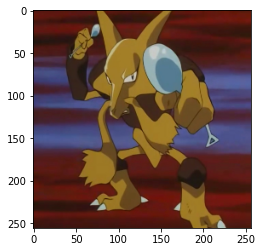

In [8]:
for (image, label) in test_dataset:
    print("Image shape", image.shape)
    print("Label shape", label.shape)
    print("-" * 100)
    print(label_encoder.inverse_transform([label]))
    plt.imshow(image)
    break

In [17]:
model = pc.create_model(RES)

In [18]:
model.summary()

Model: "Pokemon-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
re_lu_2 (ReLU)               (None, 256, 256, 16)      0         
Total params: 512
Trainable params: 480
Non-trainable params: 32
_________________________________________________________________
